# Algebra liniowa z zastosowaniami 1

## Ćwiczenia w sali komputerowej nr 7

Uzupełnij swoje dane i sprawdź czy wyświetlają się poprawnie:

In [ ]:
IMIE_NAZWISKO = ""

print(IMIE_NAZWISKO)

Na dzisiejszych zajęciach skoncentrujemy się na wybranych zagadnieniach związanych z wydajnością i optymalizacją obliczeń. Materiał zrealizuj na wydziałowym serwerze [JupyterHub](https://jupyter.wmi.amu.edu.pl/) lub wydziałowym środowisku Linux.

Na początek wczytajmy niezbędne biblioteki:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import subprocess

### Sposoby przechowywania danych w pamięci

Macierze mogą być przechowywane w pamięci jako tablica w sposób [wierszowy lub kolumnowy](https://en.wikipedia.org/wiki/Row-_and_column-major_order) (z ang. odpowiednio *row-major order* lub *column-major order*; historycznie *row-major* oznacza również *C-style*, a *column-major* oznacza *Fortran-style*).

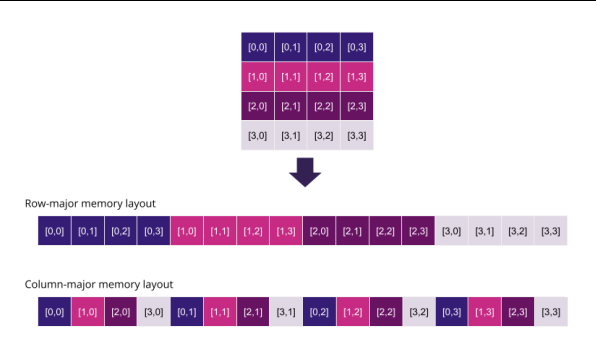

*Układ row-major i column-major. Źródło: [codee-com/open-catalog](https://github.com/codee-com/open-catalog) @ GitHub. [Apache-2.0](https://github.com/codee-com/open-catalog/?tab=Apache-2.0-1-ov-file#readme)*

*Row-major order* to sposób przechowywania macierzy w pamięci, w którym elementy wierszy są umieszczane kolejno po sobie, co pozwala na wydajniejszy dostęp do kolejnych elementów wiersza. Z kolei *column-major order* przechowuje w pamięci kolejno po sobie elementy kolumn, co jest korzystniejsze przy operacjach na kolumnach. Patrząc na przetwarzanie danych z perspektywy hierarchii wykorzystywanej [pamięci operacyjnej](https://pl.wikipedia.org/wiki/Pami%C4%99%C4%87_operacyjna), pracując na dużych macierzach dane do obliczeń są wczytywane w miarę potrzeby z [pamięci głównej RAM](https://pl.wikipedia.org/wiki/RAM) do [pamięci podręcznej procesora (*cache*)](https://pl.wikipedia.org/wiki/Pami%C4%99%C4%87_podr%C4%99czna_procesora) i ostatecznie do [rejestrów procesora](https://pl.wikipedia.org/wiki/Rejestr_procesora). Jeśli nastąpi tzw. [*cache miss*](https://en.wikipedia.org/wiki/CPU_cache#Cache_miss), to wiąże się to z opóźnieniem spowodowanym ponownym wczytaniem części potrzebnych danych do pamięci podręcznej. Biorąc pod uwagę również [schematy dostępu do pamięci](https://en.wikipedia.org/wiki/Memory_access_pattern), wybór reprezentacji przechowywania danych może znacząco przyspieszyć operacje na macierzach. *Nota bene*, samo zagadnienie sposobu przechowywania i dostępu do danych w sposób wierszowy lub kolumnowy jest w pewien sposób analogiczne do zagadnienia [kolumnowych baz danych](https://pl.wikipedia.org/wiki/CODB), które są alternatywą do tradycyjnych relacyjnych baz danych przetwarzanych w sposób wierszowy.

W Numpy tworząc tablicę [`np.array`](https://numpy.org/doc/stable/reference/generated/numpy.array.html) możemy poprzez atrybut `order` wybrać czy ma być ona przechowywana w pamięci w sposób wierszowy (`C`, _**c**ontiguous_; domyślne) czy kolumnowy (`F`, _**f**ortran_). Sprawdzenie sposobu uporządkowania danych odbywa się np. poprzez atrybut [`flags`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.flags.html). Konwersję można zrealizować np. poprzez funkcje [`np.ascontiguousarray()`](https://numpy.org/doc/stable/reference/generated/numpy.ascontiguousarray.html) i [`np.asfortranarray()`](https://numpy.org/doc/stable/reference/generated/numpy.asfortranarray.html).

W teorii (np. podczas mnożenia macierzy) bardziej powinno się nam opłacać przechowywać i przetwarzać macierz $A$ w sposób wierszowy, a $B$ w sposób kolumnowy, jeśli zamierzamy obliczyć iloczyn $AB$. Poniższy kod przeprowadza symulacje dla czterech możliwych wariantów dla macierzy o wartościach całkowitoliczbowych:

In [ ]:
def get_matrices_int(rseed, dim_k, dim_m, dim_n, X_order, Y_order):
    
    np.random.seed(rseed)
    X = np.array(np.random.randint(-100, 100, (dim_k, dim_m)), order=X_order)
    Y = np.array(np.random.randint(-100, 100, (dim_m, dim_n)), order=Y_order)
    return X, Y

def matmul_experiment(reps, X, Y):

    run_times = []
    
    for _ in range(reps):    
        time_start = time.time()
        np.matmul(X, Y)
        time_end = time.time()
        
        run_times.append(time_end - time_start)
        
    return run_times

#________________________________________________________________________

no_reps   = 5
rand_seed = 1337

k = 1001
m = 1000
n = 1002

order_lookup = [
    ('row-row',       'C', 'C'),
    ('column-column', 'F', 'F'),
    ('row-column',    'C', 'F'),
    ('column-row',    'F', 'C')
]

print(f"dim A = ({k} x {m})")
print(f"dim B = ({m} x {n})\n")
print("A @ B:")

for label, A_order, B_order in order_lookup:
    A, B = get_matrices_int(rand_seed, k, m, n, A_order, B_order)
    vals = matmul_experiment(no_reps, A, B)
    print(f"  {label:<14}: {np.min(vals):.5f} s")

*Uwaga*: obliczenia na serwerze JupyterHub w trakcie zajęć mogą być nieco wolniejsze, co w jednostkowych przypadkach może w konsekwencji dać nieco przekłamane wyniki. Poniżej znajdują się przykładowe wyniki:

```default
dim A = (1001 x 1000)
dim B = (1000 x 1002)

A @ B:
   row-row:       0.88070 s
   column-column: 0.85224 s
   row-column:    0.71104 s
   column-row:    1.33184 s
```

Zgodnie z oczekiwaniami podejście wierszowe dla $A$ i kolumnowe dla $B$ (`row-column`) dało najlepsze wyniki; z kolei `column-row` powoduje nieefektywne wykorzystanie pamięci i w konsekwencji prawie dwukrotne wydłużenie obliczeń. Domyślne podejście `row-row` jest nieco wolniejsze (ok. 20%) niż `row-column`. Przy pojedynczych obliczeniach problem ten jest oczywiście marginalny, jednak realizując wiele intensywnych obliczeń, które normalnie trwają kilka godzin, warto się zastanowić nad możliwymi sposobami ich skrócenia.

Gdybyśmy pracowali na nieobciążonym serwerze, to moglibyśmy zaobserwować, że obliczenia wykonywane były na jednym rdzeniu (zrzut z programu [`htop`](https://man7.org/linux/man-pages/man1/htop.1.html)):

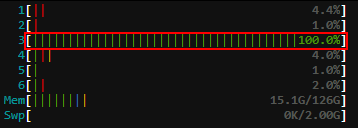

W dalszej części materiałów zobaczymy jak rozproszyć te obliczenia na wiele procesorów, ale najpierw sprawdźmy jeszcze jak wygląda wydajność powyższych symulacji dla innych rozmiarów macierzy.

##### Zadanie 1 (4 pkt.)

Będziemy teraz chcieli przeprowadzić symulację dla kilku rozmiarów macierzy kwadratowych $n \times n$ o wartościach całkowitoliczbowych. Oczekiwany końcowy wykres będzie wyglądał mniej więcej tak:

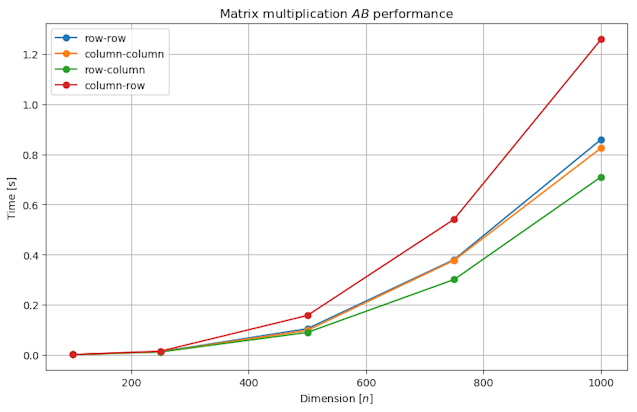

Uzupełnij poniższe funkcje `get_ABs_int()`, `get_all_times()` i `get_plot_min_times()`. Przypadki testowe i spodziewane wyniki znajdują się poniżej definicji funkcji.

In [ ]:
def get_ABs_int(rseed, dims):
    """
    Generuje pary macierzy (A, B) o wartościach całkowitoliczbowych przy pomocy get_matrices_int() 
    dla różnych wymiarów i kolejności przechowywania elementów.

    Args:
        rseed (int): Ziarno generatora liczb losowych.
        dims (list): Lista wymiarów n x n macierzy, np. [200, 350, 1700] oznacza
                     generowanie macierzy 200 x 200, 350 x 350 i 1700 x 1700

    Returns:
        dict: Słownik zawierający listy par macierzy (A, B) dla każdego kolejnego wymiaru.
    """

    data_ABs = {
        'row-row':       [],
        'column-column': [],
        'row-column':    [],
        'column-row':    []
    }

    # UMIEŚĆ SWÓJ KOD TUTAJ
    # możesz skorzystać z wcześniej zdefiniowanej zmiennej 'order_lookup'

    return data_ABs

Np. w wyniku `get_ABs_int(1337, [2, 3])` otrzymamy dla klucza `row-row` listę par macierzy o wartościach całkowitoliczbowych:

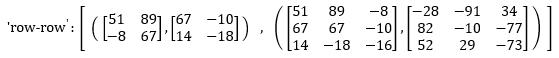

Macierze w kolejnych kluczach będą miały takie same wartości, ale ich sposób przechowywania w pamięci będzie inny.

Przypadek testowy dla `get_ABs_int()`:

```python
test_data = get_ABs_int(1337, [2, 3])
for key, list_of_matrices in test_data.items():
    print(f"{key}:")
    for A, B in list_of_matrices:
        print(f"A, {A.dtype}, {'row' if A.flags['C_CONTIGUOUS'] else 'column'}")
        print(A)
        print(f"B, {B.dtype}, {'row' if B.flags['C_CONTIGUOUS'] else 'column'}")
        print(B)
    print("")
```

Spodziewany wynik:

```plaintext
row-row:
A, int64, row
[[51 89]
 [-8 67]]
B, int64, row
[[ 67 -10]
 [ 14 -18]]
A, int64, row
[[ 51  89  -8]
 [ 67  67 -10]
 [ 14 -18 -16]]
B, int64, row
[[-28 -91  34]
 [ 82 -10 -77]
 [ 52  29 -73]]

column-column:
A, int64, column
[[51 89]
 [-8 67]]
B, int64, column
[[ 67 -10]
 [ 14 -18]]
A, int64, column
[[ 51  89  -8]
 [ 67  67 -10]
 [ 14 -18 -16]]
B, int64, column
[[-28 -91  34]
 [ 82 -10 -77]
 [ 52  29 -73]]

row-column:
A, int64, row
[[51 89]
 [-8 67]]
B, int64, column
[[ 67 -10]
 [ 14 -18]]
A, int64, row
[[ 51  89  -8]
 [ 67  67 -10]
 [ 14 -18 -16]]
B, int64, column
[[-28 -91  34]
 [ 82 -10 -77]
 [ 52  29 -73]]

column-row:
A, int64, column
[[51 89]
 [-8 67]]
B, int64, row
[[ 67 -10]
 [ 14 -18]]
A, int64, column
[[ 51  89  -8]
 [ 67  67 -10]
 [ 14 -18 -16]]
B, int64, row
[[-28 -91  34]
 [ 82 -10 -77]
 [ 52  29 -73]]
```

In [ ]:
def get_all_times(data_ABs, reps):
    """
    Wykonuje mnożenie dla każdej pary macierzy przy pomocy matmul_experiment() i zapisuje czasy wykonania.

    Args:
        data_ABs (dict): Słownik zawierający pary macierzy (A, B).
        reps (int): Liczba powtórzeń mnożenia macierzy.

    Returns:
        dict: Słownik zawierający listy list czasów wykonania dla każdego kolejnego wymiaru.
    """

    data_times = {
        'row-row':       [],
        'column-column': [],
        'row-column':    [],
        'column-row':    []
    }

    # UMIEŚĆ SWÓJ KOD TUTAJ

    return data_times

Przypadek testowy dla `get_all_times()`:

```python
times_data = get_all_times(test_data, 4)
for key, list_of_all_dim_times in times_data.items():
    print(f"{key}:")
    for times_list in list_of_all_dim_times:
        print([type(t) for t in times_list])
    print("")
```

Spodziewany wynik:

```plaintext
row-row:
[<class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>]
[<class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>]

column-column:
[<class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>]
[<class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>]

row-column:
[<class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>]
[<class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>]

column-row:
[<class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>]
[<class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>]


```

In [ ]:
def get_plot_min_times(data_times):
    """
    Wyznacza minimalne czasy wykonania mnożenia macierzy dla każdego wymiaru.

    Args:
        data_times (dict): Słownik zawierający listy list czasów wykonania.

    Returns:
        dict: Słownik zawierający listy minimalnych czasów wykonania dla każdego kolejnego wymiaru.
    """

    data_to_plot = {
        'row-row':       [],
        'column-column': [],
        'row-column':    [],
        'column-row':    []
    }

    # UMIEŚĆ SWÓJ KOD TUTAJ

    return data_to_plot

Przypadek testowy dla `get_plot_min_times()`:

```python
plot_data = get_plot_min_times(times_data)
for key, min_dims_times in plot_data.items():
    print(f"{key}:")
    print([min_time == np.min(times_data[key][i]) for i, min_time in enumerate(min_dims_times)])
```

Spodziewany wynik:

```plaintext
row-row:
[True, True]
column-column:
[True, True]
row-column:
[True, True]
column-row:
[True, True]
```

Przeprowadźmy teraz symulację dla $n \in \{100, 250, 500, 750, 1000\}$ z 5 powtórzeniami i zwizualizujmy wyniki:

In [ ]:
def simulation_dims_int(no_reps, rand_seed, n_dims):

    data_ABs     = get_ABs_int(rand_seed, n_dims)
    data_times   = get_all_times(data_ABs, no_reps)
    data_to_plot = get_plot_min_times(data_times)

    return data_to_plot


def visualize_dims(n_dims, data_to_plot, log_y_scale=False):
    plt.figure(figsize=(10, 6))

    for key in data_to_plot.keys():
        plt.plot(n_dims, data_to_plot[key], marker='o', linestyle='-', label=key)

    if log_y_scale:
        plt.yscale("log")
    plt.xlabel('Dimension [$n$]')
    plt.ylabel('Time [s] (log)' if log_y_scale else 'Time [s]')
    plt.title('Matrix multiplication $AB$ performance')
    plt.legend()
    plt.grid(True)
    plt.show()

no_reps   = 5
rand_seed = 1337
n_dims = [100, 250, 500, 750, 1000]

data_to_plot_int = simulation_dims_int(no_reps, rand_seed, n_dims)
visualize_dims(n_dims, data_to_plot_int)

### BLAS i LAPACK

Podczas zajęć wykorzystywaliśmy bibliotekę NumPy do obliczeń związanych z algebrą liniową. W dokumentacji części funkcji mogliśmy znaleźć kilka następujących wzmianek:

* [`np.matmul()`](https://numpy.org/doc/stable/reference/generated/numpy.matmul.html):

  > It uses an optimized **BLAS** library when possible.
  
* [`np.linalg.det()`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.det.html)

  > The determinant is computed via LU factorization using the **LAPACK** routine `z/dgetrf`.
  
NumPy oraz podobne jej biblioteki korzystają z zewnętrznych implementacji operacji i algorytmów, które są zawarte w innych bibliotekach. W tym przypadku mówimy::

1. [Basic Linear Algebra Subprograms (BLAS)](https://en.wikipedia.org/wiki/Basic_Linear_Algebra_Subprograms),
2. [Linear Algebra Package (LAPACK)](https://en.wikipedia.org/wiki/LAPACK).

BLAS to zestaw podstawowych niskopoziomowych procedur służących do wykonywania operacji na macierzach i wektorach, takich jak np. mnożenie i dodawanie. Z kolei LAPACK jest wysokopoziomową biblioteką, która intensywnie wykorzystuje BLAS i służy do rozwiązywania bardziej złożonych problemów, np. takich jak obliczanie rozkładów macierzy, rozwiązywania układów równań liniowych i obliczania wartości własnych. W dalszej części materiałów skoncentrujemy się na BLAS.

#### Netlib

Podstawowe referencyjne implementacje BLAS i LAPACK, definiujące ogólne [API](https://pl.wikipedia.org/wiki/Interfejs_programowania_aplikacji) i stanowiące odniesienie dla innych implementacji, są dostarczane przez repozytorium Netlib:

* <https://www.netlib.org/blas>,
* <https://www.netlib.org/lapack>.

Netlib zaimplementowany jest w języku Fortran i wystawia API w języku C poprzez biblioteki CBLAS i LAPACKE.

Operacje BLAS podzielone są na kilka poziomów (ang. *levels*):

* Level 1 BLAS - operacje skalarne, wektorowe i typu *wektor-wektor*, 
* Level 2 BLAS - operacje typu *macierz-wektor*
* Level 3 BLAS - operacje typu *macierz-macierz*.

Przegląd możliwych operacji na każdym poziomie dostępny jest w sekcji [*BLAS Routines*](https://www.netlib.org/blas/#_blas_routines) (linki do dokumentacji poszczególnych funkcji co prawda są nieaktywne, ale nadal można do nich dotrzeć poprzez [dokumentację HTML](https://www.netlib.org/lapack/explore-html/modules.html)) oraz w pliku [*quick reference*](https://www.netlib.org/blas/blasqr.pdf). Spójrzmy na dwie przykładowe operacje.

---

**saxpy:** $y = a \cdot x + y$

Mając dwa wektory $x$ i $y$ długości $n$ oraz skalar $a$, wszystkie o wartościach zmiennoprzecinkowych pojedynczej precyzji (*single precision*), operacja ta powoduje nadpisanie wektora $y$ w następujący sposób:

```default
for i = 1:n
   y(i) = a*x(i) + y(i)
end
```

Nazwa *saxpy* to skrót od _**s**ingle precision $\mathbf{ax}$ **p**lus $\mathbf{y}$_.

W dokumentacji możemy zauważyć jeszcze trzy inne wersje:

1. *daxpy* (_**d**ouble precision_),
2. *caxpy* (_single **c**omplex_),
3. *zaxpy* (_double complex_).

Łącznie wszystkie cztery operacje występują w dokumentacji jako grupa [*axpy*](https://www.netlib.org/lapack/explore-html/d5/d4b/group__axpy.html).

---

**sgemm**: $C = \alpha \cdot \text{op}(A) \cdot \text{op}(B) + \beta \cdot C$

* $\alpha$ i $\beta$ to skalary,
* $A$, $B$ i $C$ to macierze,
* $\text{op}(X) = X$ lub $\text{op}(X) = X^T$,
* $\text{op}(A)$ jest macierzą $m \times k$, $\text{op}(B)$ jest macierzą $k \times n$ i $\text{op}(C)$ jest macierzą $m \times n$.

Skrót *sgemm* pochodzi od _**s**ingle-precision **ge**neral **m**atrix **m**ultiply_.

Podobnie jak w poprzednim przykładzie, możliwe są cztery warianty tej operacji (*sgemm*, *dgemm*, *cgemm* i *zgemm*) i występują w dokumentacji jako grupa [*gemm*](https://www.netlib.org/lapack/explore-html/dd/d09/group__gemm.html).

---

Z praktycznego punktu widzenia użycie poszczególnych funkcji BLAS i LAPACK odbywa się w sposób automatyczny i jest transparentne dla zwykłego użytkownika, np. użycie w NumPy funkcji `np.matmul()` na macierzach o wartościach zmiennoprzecinkowych może *de facto* być realizowane przez wywołanie niskopoziomowej funkcji *sgemm*.

W Pythonie wywołania *explicite* funkcji BLAS i LAPACK można zrealizować poprzez bibliotekę [SciPy](https://docs.scipy.org/doc/scipy/reference/linalg.html#low-level-routines), tj. moduły [`scipy.linalg.blas`](https://docs.scipy.org/doc/scipy/reference/linalg.blas.html#module-scipy.linalg.blas) i [`scipy.linalg.lapack`](https://docs.scipy.org/doc/scipy/reference/linalg.lapack.html#module-scipy.linalg.lapack). W ostrzeżeniu tych modułów znajdziemy informację:

> These functions do little to no error checking. It is possible to cause crashes by mis-using them.

Patrząc na to szerzej, część mniej lub bardziej egzotycznych/nowych bibliotek, np. z zakresu uczenia maszynowego, faktycznie może pomijać sprawdzanie danych wejściowych (w końcu chcą być szybsze od konkurencyjnych bibliotek) lub łapanie wyjątków, co w konsekwencji może prowadzić do nieoczekiwanych błędów. Z perspektywy użytkownika nawet zwykłe kojarzenie nazewnictwa funkcji BLAS i LAPACK może być pomocne przy debugowaniu bardziej złożonych projektów realizujących operacje na macierzach i wektorach (np. gdy następuje próba mnożenia macierzy o niekompatybilnych wymiarach).

##### Zadanie 2 (2 pkt)

Sprawdź w dokumentacji BLAS grupę operacji *trsv*, tj. napisz:

1. z którego jest poziomu (*level*),
2. co realizuje,
3. czy przed ich realizacją wykonywane są testy sprawdzające poprawność danych wejściowych.

**Odpowiedź:**

1. UMIEŚĆ SWOJĄ ODPOWIEDŹ TUTAJ
2. UMIEŚĆ SWOJĄ ODPOWIEDŹ TUTAJ
3. UMIEŚĆ SWOJĄ ODPOWIEDŹ TUTAJ

---

#### Inne implementacje BLAS

Standardowa implementacja dostarczana przez Netlib jest jednowątkowa i nie jest zoptymalizowana, ale jak wspomniano wyżej, jest to biblioteka referencyjna i definiuje API dla operacji na wektorach i macierzach. W praktyce jako biblioteki BLAS wykorzystuje się np.:

* [OpenBLAS](https://www.openblas.net),
* [Intel MKL](https://en.wikipedia.org/wiki/Math_Kernel_Library),
* [NVBLAS](https://docs.nvidia.com/cuda/nvblas/) i [cuBLAS](https://developer.nvidia.com/cublas).

NVBLAS i cuBLAS jest rozwijany przez Nvidię i do obliczeń wykorzystuje [GPU](https://pl.wikipedia.org/wiki/Procesor_graficzny) (obecnie nie implementuje całego API, więc część operacji jest nadal realizowanych na [CPU](https://pl.wikipedia.org/wiki/Procesor) np. przez OpenBLAS). Z innych bibliotek można też wspomnieć o intensywnie rozwijanym [BLIS](https://en.wikipedia.org/wiki/BLIS_(software)) i raczej już opuszczonym [ATLAS](https://en.wikipedia.org/wiki/Automatically_Tuned_Linear_Algebra_Software). Ciekawostką jest biblioteka [GotoBLAS](https://en.wikipedia.org/wiki/GotoBLAS), która była rozwijana przez [Kazushige Goto](http://web.archive.org/20121014060935/www.nytimes.com/2005/11/28/technology/28super.html?scp=1&sq=Kazushige%20Goto&st=cse) i obecnie stanowi fundament OpenBLAS, a K. Goto poprzez ręczne optymalizacje doprowadził do tak wyśrubowanych wyników, że Intel zatrudnił go do pracy nad biblioteką Intel MKL.

W 2016 r. przeprowadziliśmy na Wydziale [testy wydajnościowe](https://github.com/andre-wojtowicz/blas-benchmarks) dostępnych bibliotek BLAS na posiadanym przez Wydział sprzęcie. Z perspektywy administratora klastra obliczeniowego, który dostarcza badaczom lub działom R&D infrastrukturę do obliczeń, tego typu testy pozwalają dostarczyć najlepsze rozwiązanie do konkretnego zastosowania.

#### NumPy i BLAS

Biblioteka NumPy instalowana przez `pip` zawiera własną kopię OpenBLAS. Pod Linuxem plik biblioteki znajduje się np. w `~/.local/lib/python3.10/site-packages/numpy.libs/` i jest ładowany zamiast bibliotek zainstalowanych w systemie.

Z kolei np. wersja Debianowa pakietu `python3-numpy` korzysta z systemowej biblioteki BLAS - taka konfiguracja zastosowana jest na wydziałowych laboratoriach i będziemy z niej korzystali.

Więcej na temat sposobów doboru biblioteki BLAS można znaleźć w [dokumentacji](https://numpy.org/install/#numpy-packages--accelerated-linear-algebra-libraries).

#### BLAS w Debianie

W dokumentacji Debiana możemy znaleźć informację o [pakietach](https://wiki.debian.org/DebianScience/LinearAlgebraLibraries) zawierających poszczególne biblioteki implementujące BLAS. Jeśli jest zainstalowanych kilka różnych wersji, to ustawienie domyślnej biblioteki odbywa się poprzez polecenie [`sudo update-alternatives --config libblas.so.3-x86_64-linux-gnu`](https://man7.org/linux/man-pages/man1/update-alternatives.1.html) (nie uruchamiaj tego polecenia w laboratoriach, ponieważ nie masz uprawnień administratora). Dostęp do biblioteki odbywa się przez bibliotekę współdzieloną `libblas.so`, która jest dowiązaniem symbolicznym do konkretnego pliku biblioteki.

Poszukajmy gdzie znajduje się biblioteka BLAS:

In [ ]:
!whereis libblas

Spodziewany wynik:

```default
libblas: /usr/lib/x86_64-linux-gnu/libblas.so /usr/lib/x86_64-linux-gnu/libblas.a
```

Możemy sprawdzić na co wskazuje dowiązanie symboliczne naszej biblioteki współdzielonej:

In [ ]:
!ls -al /usr/lib/x86_64-linux-gnu/libblas.so

Spodziewany wynik:

```default
lrwxrwxrwx 1 root root 45 Sep 21  2022 /usr/lib/x86_64-linux-gnu/libblas.so -> /etc/alternatives/libblas.so-x86_64-linux-gnu
```

Po drodze występuje kilka dowiązań symbolicznych, więc lepiej będzie sprawdzić na co na końcu wskazuje to dowiązanie:

In [ ]:
!readlink -f /usr/lib/x86_64-linux-gnu/libblas.so

Spodziewany wynik:

```default
/usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3
```

Jak widać, system został skonfigurowany tak, by wykorzystywać bibliotekę OpenBLAS w wersji [*pthread*](https://pl.wikipedia.org/wiki/POSIX_Threads), czyli wielowątkowej. Spróbujemy to wykorzystać do naszych obliczeń z poprzedniego zadania.

##### Zadanie 3 (2 pkt.)

Spójrzmy jeszcze raz na komentarz w [`np.matmul()`](https://numpy.org/doc/stable/reference/generated/numpy.matmul.html):

> It uses an optimized BLAS library **when possible**.

W poprzednim zadaniu tworzyliśmy i mnożyliśmy macierze o wartościach całkowitoliczbowych (używaliśmy [`np.random.randint()`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randint.html)). Z dokumentacji BLAS wynika, że operacje z grupy *gemm* mają wersje tylko dla typów zmiennoprzecinkowych lub zespolonych, w związku z czym nie były wykorzystywane optymalizacje BLAS.

Uzupełnij poniższe funkcje `get_matrices_float()` i `get_ABs_float()`. Przypadki testowe i spodziewane wyniki znajdują się poniżej definicji funkcji.

In [ ]:
def get_matrices_float(rseed, dim_k, dim_m, dim_n, X_order, Y_order):
    
    np.random.seed(rseed)
    # UMIEŚĆ SWÓJ KOD TUTAJ
    X = None
    Y = None
    return X, Y

Przypadek testowy:

```python
X, Y = get_matrices_float(1337, 2, 2, 3, 'F', 'C')
print(X)
print(X.dtype)
print(X.flags['F_CONTIGUOUS'])
print(Y)
print(Y.dtype)
print(Y.flags['C_CONTIGUOUS'])
```

Spodziewany wynik:

```plaintext
[[51. 89.]
 [-8. 67.]]
float32
True
[[ 67. -10.  14.]
 [-18. -16. -28.]]
float32
True
```

In [ ]:
def get_ABs_float(rseed, dims):
    """
    Generuje pary macierzy (A, B) o wartościach całkowitoliczbowych przy pomocy get_matrices_float() 
    dla różnych wymiarów i kolejności przechowywania elementów.

    Args:
        rseed (int): Ziarno generatora liczb losowych.
        dims (list): Lista wymiarów n x n macierzy, np. [200, 350, 1700] oznacza
                     generowanie macierzy 200 x 200, 350 x 350 i 1700 x 1700

    Returns:
        dict: Słownik zawierający listy par macierzy (A, B) dla każdego kolejnego wymiaru.
    """

    data_ABs = {
        'row-row':       [],
        'column-column': [],
        'row-column':    [],
        'column-row':    []
    }

    # UMIEŚĆ SWÓJ KOD TUTAJ

    return data_ABs

Np. w wyniku `get_ABs_float(1337, [2, 3])` otrzymamy dla klucza `row-row` listę par macierzy o wartościach rzeczywistych:

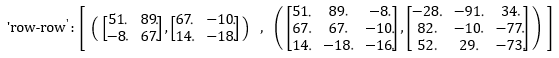

Macierze w kolejnych kluczach będą miały takie same wartości, ale ich sposób przechowywania w pamięci będzie inny.

Przypadek testowy dla `get_ABs_float()`:

```python
test_data = get_ABs_float(1337, [2, 3])
for key, list_of_matrices in test_data.items():
    print(f"{key}:")
    for A, B in list_of_matrices:
        print(f"A, {A.dtype}, {'row' if A.flags['C_CONTIGUOUS'] else 'column'}")
        print(A)
        print(f"B, {B.dtype}, {'row' if B.flags['C_CONTIGUOUS'] else 'column'}")
        print(B)
    print("")
```

Spodziewany wynik:

```plaintext
row-row:
A, float32, row
[[51. 89.]
 [-8. 67.]]
B, float32, row
[[ 67. -10.]
 [ 14. -18.]]
A, float32, row
[[ 51.  89.  -8.]
 [ 67.  67. -10.]
 [ 14. -18. -16.]]
B, float32, row
[[-28. -91.  34.]
 [ 82. -10. -77.]
 [ 52.  29. -73.]]

column-column:
A, float32, column
[[51. 89.]
 [-8. 67.]]
B, float32, column
[[ 67. -10.]
 [ 14. -18.]]
A, float32, column
[[ 51.  89.  -8.]
 [ 67.  67. -10.]
 [ 14. -18. -16.]]
B, float32, column
[[-28. -91.  34.]
 [ 82. -10. -77.]
 [ 52.  29. -73.]]

row-column:
A, float32, row
[[51. 89.]
 [-8. 67.]]
B, float32, column
[[ 67. -10.]
 [ 14. -18.]]
A, float32, row
[[ 51.  89.  -8.]
 [ 67.  67. -10.]
 [ 14. -18. -16.]]
B, float32, column
[[-28. -91.  34.]
 [ 82. -10. -77.]
 [ 52.  29. -73.]]

column-row:
A, float32, column
[[51. 89.]
 [-8. 67.]]
B, float32, row
[[ 67. -10.]
 [ 14. -18.]]
A, float32, column
[[ 51.  89.  -8.]
 [ 67.  67. -10.]
 [ 14. -18. -16.]]
B, float32, row
[[-28. -91.  34.]
 [ 82. -10. -77.]
 [ 52.  29. -73.]]
```

Wykonajmy jeszcze raz symulacje, ale tym razem rzutując wygenerowane macierze na typ zmiennoprzecinkowy, tj. `np.float32`, oraz sprawdźmy szerszy zakres $n$, tj. $n \in \{100, 250, 500, 750, 1000, 1500, 2000\}$.

Spodziewany wynik:

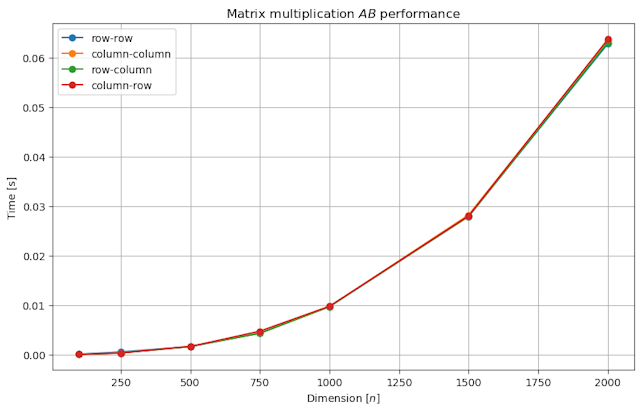

In [ ]:
def simulation_dims_float(no_reps, rand_seed, n_dims):

    data_ABs     = get_ABs_float(rand_seed, n_dims)
    data_times   = get_all_times(data_ABs, no_reps)
    data_to_plot = get_plot_min_times(data_times)

    return data_to_plot

no_reps   = 5
rand_seed = 1337
n_dims = [100, 250, 500, 750, 1000, 1500, 2000]

data_to_plot_float = simulation_dims_float(no_reps, rand_seed, n_dims)
visualize_dims(n_dims, data_to_plot_float)

 Powinniśmy zauważyć, że w teraz przy wartościach zmiennoprzecinkowych sposób przechowywania danych w pamięci nie ma większej różnicy.
 
 Porównajmy czas wykonania operacji w stosunku do wyników z Zadania 1.

 Spodziewany wynik:

 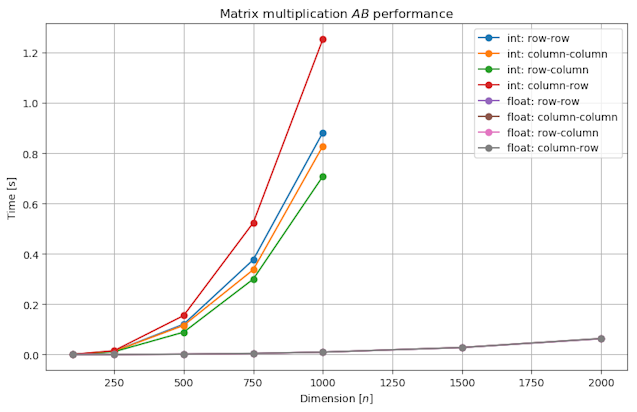

In [ ]:
# uzupełnienie wyników data_to_plot_int o puste wartości dla n równego 1500 i 2000
data_to_plot_int_filled = {k: v + [None, None] for k, v in data_to_plot_int.items()}

# połączenie wyników z obu eksperymentów
data_to_plot_combined = {
    **dict(map(lambda kv: ("int: " + kv[0], kv[1]), data_to_plot_int_filled.items())),
    **dict(map(lambda kv: ("float: " + kv[0], kv[1]), data_to_plot_float.items())),
}

visualize_dims(n_dims, data_to_plot_combined)

Możemy wyświetlić te same wyniki, ale w skali logarytmicznej na osi Y. Skala logarytmiczna pozwala czasem lepiej porównywać wartości o dużej rozpiętości, uwydatniając proporcje i różnice między danymi; skala ta jest dość często wykorzystywana w pracach naukowych podczas analizowania wydajności systemów i algorytmów.

Spodziewany wynik:

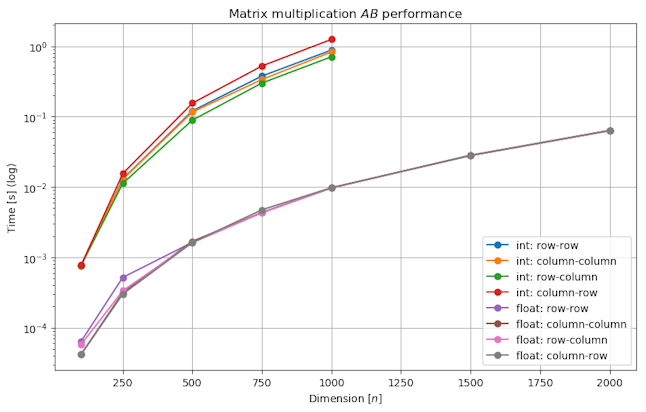

In [ ]:
visualize_dims(n_dims, data_to_plot_combined, log_y_scale=True)

---

**Komentarz do spodziewanych wyników Zadania 1 i 3**

Gdybyśmy pracowali w izolowanym środowisku systemowym, to moglibyśmy zauważyć, że teraz podczas obliczeń wykorzystywane są wszystkie rdzenie:

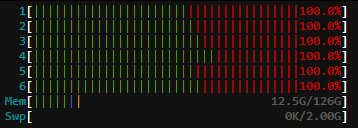

Eksperymenty wykonane na wydziałowej infrastrukturze komputerowej w 2025 r. pokazują, że w Zadaniu 1 wyniki dla $n=1000$ powinny oscylować między $0.7$ a $1.2$ sekundy; z kolei w Zadaniu 3 nawet dla $n=2000$ w najgorszym przypadku wyniki powinny być gdzieś poniżej $0.1$ sekundy. Oczywiście w zależności od sprzętu dokładne wyniki mogą być różne, jednak stosunek przyrostu prędkości powinien być mniej więcej zachowany.

Powyższe eksperymenty potwierdzają ogólną zasadę dotyczącą obliczeń wysokowydajnych (ang. [_**h**igh-**p**erformance **c**omputing_, HPC](https://en.wikipedia.org/wiki/High-performance_computing)), że warto [wektoryzować obliczenia](https://en.wikipedia.org/wiki/Automatic_vectorization) (czyli wyrażać je w języku operacji na wektorach i macierzach) oraz że stojąc przed perspektywą intensywnych i długotrwałych obliczeń warto na początku przeprowadzić niewielkie symulacje tak, by móc dobrać ich optymalny wariant pod kątem sprzętowym.

---

#### Wydajność bibliotek BLAS

Sprawdźmy jakie inne biblioteki BLAS są zainstalowane na naszym środowisku obliczeniowym:

In [ ]:
!find /usr/lib/x86_64-linux-gnu/*/ -name "libblas.so*" | sort

Spodziewane wyniki:

```default
/usr/lib/x86_64-linux-gnu/atlas/libblas.so.3
/usr/lib/x86_64-linux-gnu/atlas/libblas.so.3.10.3
/usr/lib/x86_64-linux-gnu/blas/libblas.so
/usr/lib/x86_64-linux-gnu/blas/libblas.so.3
/usr/lib/x86_64-linux-gnu/blas/libblas.so.3.9.0
/usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so
/usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3
```

Poza OpenBLAS mamy dostęp do ATLAS oraz Netlib. Sprawdzimy jaką wydajność otrzymamy stosując każdą z tych bibliotek podczas mnożenia macierzy.

Co prawda nie mamy uprawnień administratora by poprzez [`update-alternatives`](https://man7.org/linux/man-pages/man1/update-alternatives.1.html) zaktualizować dowiązanie symboliczne do `/usr/lib/x86_64-linux-gnu/libblas.so`, ale możemy zastosować mechanizm [`LD_PRELOAD`](https://stackoverflow.com/a/426260). Dodatkowo przy pomocy polecenia [`nice`](https://man7.org/linux/man-pages/man2/nice.2.html) ustawimy naszym obliczeniom niski priorytet w systemie, tak aby nie obciążać zbytnio współdzielonego serwera.

In [ ]:
blas_libs = {"Netlib":   "/usr/lib/x86_64-linux-gnu/blas/libblas.so",
             "Atlas":    "/usr/lib/x86_64-linux-gnu/atlas/libblas.so.3",
             "OpenBLAS": "/usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so"}

matrix_size = 2000
random_seed = 1337

__script__ = f"""
import numpy as np
np.random.seed({random_seed})
A = np.random.rand({matrix_size}, {matrix_size})
B = np.random.rand({matrix_size}, {matrix_size})
A @ B
""".strip().replace("\n", ";")

print(f"dim A = ({matrix_size} x {matrix_size})")
print(f"dim B = ({matrix_size} x {matrix_size})\n")
print("A @ B:")

for name in blas_libs:
    
    lib_so_path = blas_libs[name]
    
    command = ["bash", "-c", f'LD_PRELOAD="{lib_so_path}" python3 -c "{__script__}"']

    start_time = time.time()
    process = subprocess.run(["nice", "-n", "19"] + command)
    end_time = time.time()
    
    elapsed_time = end_time - start_time

    if process.returncode != 0:
        raise Exception(f"Execution for {name} returned {process.returncode}")

    print(f"   {name: >8}: {elapsed_time:4.2f} s")

Spodziewane orientacyjne wyniki:

```default
dim A = (2000 x 2000)
dim B = (2000 x 2000)

A @ B:
     Netlib: 4.73 s
      Atlas: 1.30 s
   OpenBLAS: 0.25 s
```

Jak widać, OpenBLAS w tym przypadku wykonuje obliczenia istotnie szybciej niż ATLAS i Netlib.

##### Zadanie 4 (1 pkt)

Przetestujemy teraz wydajność bibliotek Netlib, ATLAS i OpenBLAS w mnożeniu macierzy dla 4 wariantów uporządkowania danych w pamięci. Spodziewany końcowy wynik:

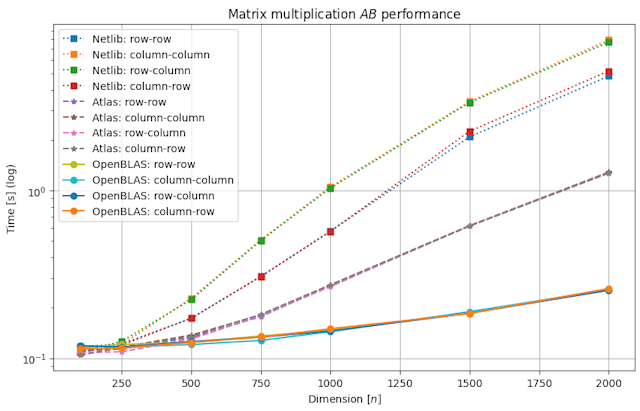

Na początek wywołaj poniższy kod, tak aby uzyskać dane do zwizualizowania:

In [ ]:
def simulation_dims_blaslibs(no_reps, rand_seed, n_dims, blas_libs, order_lookup):        

    data_to_plot = {}
    
    for libname in blas_libs:
        print(f"{libname}:")
        lib_so_path = blas_libs[libname]
        
        for ordername, A_order, B_order in order_lookup:
            print(f"   {ordername:<13}: ", end="")
        
            data_to_plot[f"{libname}: {ordername}"] = []
        
            for dim in n_dims:
                print(f"{dim} x {dim}", end="")
        
                __script__ = f"""
                import numpy as np
                np.random.seed({rand_seed})
                A = np.array(np.random.rand({dim}, {dim}), order='{A_order}')
                B = np.array(np.random.rand({dim}, {dim}), order='{B_order}')
                A @ B
                """.strip().replace("\n", ";")

                cmd = ["bash", "-c", f'LD_PRELOAD="{lib_so_path}" python3 -c "{__script__}"']
                
                tmp = []
                for _ in range(no_reps):
                    print(f".", end="")
                    
                    start_time = time.time()
                    process = subprocess.run(["nice", "-n", "19"] + cmd)
                    end_time = time.time()
                    
                    if process.returncode != 0:
                        raise Exception(f"Execution for {libname} returned {process.returncode}")

                    elapsed_time = end_time - start_time

                    tmp.append(elapsed_time)
                    
                data_to_plot[f"{libname}: {ordername}"].append(np.min(tmp))
                print(" ", end="")
                
            print("")
    
    return data_to_plot
        
no_reps   = 3
rand_seed = 1337
n_dims = [100, 250, 500, 750, 1000, 1500, 2000]

data_to_plot_blaslibs = simulation_dims_blaslibs(no_reps, rand_seed, n_dims, blas_libs, order_lookup)

Będziemy mieli teraz do zwizualizowania sporo danych, zatem musimy zwiększyć czytelność prezentowanych wyników.

Uzupełnij poniższą funkcję `get_styling()`, która dla zadanej początkowej nazwy klucza będzie zwracać odpowiednią parę [markera](https://matplotlib.org/stable/api/markers_api.html) i [stylu linii](https://matplotlib.org/stable/gallery/lines_bars_and_markers/linestyles.html) zgodnego z Matplotlib. Domyślnie ma być zwracane odpowiednio `o` i `-`.

Przypadek testowy:

```python
graphics = {
    "Netlib":   ("s", "dotted"),
    "Atlas":    ("*", "--"),
    "OpenBLAS": ("o", "-")
}
print(get_styling("Netlib: row-column", graphics))
print(get_styling("Netlib: column-column", graphics))
print(get_styling("Intel MKL: row-row", graphics))
print(get_styling("Atlas: column-column", graphics))
print(get_styling("Atlas: row-row", graphics))
print(get_styling("OpenBLAS: column-column", graphics))
print(get_styling("OpenBLAS: row-column", graphics))
```

Oczekiwany wynik:

```plaintext
('s', 'dotted')
('s', 'dotted')
('o', '-')
('*', '--')
('*', '--')
('o', '-')
('o', '-')
```

In [ ]:
def get_styling(data_key, graphics_dict):
    # UMIEŚĆ SWÓJ KOD TUTAJ
    
    return None, None

Uruchom teraz poniższy kod aby zwizualizować wyniki:

In [ ]:
graphics = {
    "Netlib":   ("s", "dotted"),
    "Atlas":    ("*", "--"),
    "OpenBLAS": ("o", "-")
}

def visualize_blis_dims(n_dims, data_to_plot, graphics, log_y_scale=False):
    plt.figure(figsize=(10, 6))

    for data_key in data_to_plot.keys():
        p_marker, p_linestyle = get_styling(data_key, graphics)
            
        plt.plot(n_dims, data_to_plot[data_key], marker=p_marker, linestyle=p_linestyle, label=data_key)

    if log_y_scale:
        plt.yscale("log")
    plt.xlabel('Dimension [$n$]')
    plt.ylabel('Time [s] (log)' if log_y_scale else 'Time [s]')
    plt.title('Matrix multiplication $AB$ performance')
    plt.legend()
    plt.grid(True)
    plt.show()
        
visualize_blis_dims(n_dims, data_to_plot_blaslibs, graphics, log_y_scale=True)

### Odtwarzalność wyników obliczeń

Materiał zakończymy krótkim komentarzem dotyczącym odtwarzalności (reprodukowalności) wyników obliczeń.

Używając różnych bibliotek, które stosują zrównoleglenie obliczeń, może się zdarzyć, że uzyskamy [nieco inne wyniki](https://scicomp.stackexchange.com/a/26139). Co więcej, biblioteki stosują [różne optymalizacje](https://scicomp.stackexchange.com/a/25296) w zależności od [mikroarchitektury procesora](https://pl.wikipedia.org/wiki/Mikroarchitektura_procesora), tj. pod konkretną mikroarchitekturę jest pisany tzw. kernel, czyli funkcja wywoływana na procesorze masowo równoległym (można to zaobserwować np. w [kodzie źródłowym OpenBLAS](https://github.com/OpenMathLib/OpenBLAS/tree/develop/kernel/x86_64)). Co prawda istnieją biblioteki BLAS stworzone pod kątem odtwarzalności obliczeń, np. [ReproBLAS](http://bebop.cs.berkeley.edu/reproblas/), jednak najczęściej odbywa się to kosztem wydajności.

Ciekawym przypadkiem może być próba obliczenia wyznacznika dość prostej macierzy:

```python
import numpy as np

B = np.array([
    [1,2,3],
    [4,5,6],
    [7,8,9]
    ], dtype=np.float64)

print(np.linalg.det(B))
```

Obecnie w większości przypadków zwrócony wynik będzie wynosił `0.0` (czyli tyle, ile powinien), jednak w dość specyficznej sytuacji możemy uzyskać `6.66133814775094e-16`, czyli "prawie zero". Można zaobserwować te różnice w bibliotece [OpenBLAS](https://github.com/OpenMathLib/OpenBLAS/issues/2779#issuecomment-677396882) wykonując obliczenia na procesorze Intel np. o mikroarchitekturze Ivy Bridge (np. i5-3570) oraz na jakimś nowszym od niego procesorze, np. z mikroarchitekturą Haswell, który posiada w OpenBLAS poprawkę w kernelach *gemm* stosowanych do mnożenia macierzy.

**Przykład**

Jeśli pracujesz w laboratorium wydziałowym na stacjonarnym komputerze pod Linuxem, to możesz wykonać poniższy eksperyment.

Na początku sprawdźmy na jakim sprzęcie pracujemy:

```bash
$ lscpu | grep "Model name"
```

Przykładowy wynik:

```plaintext
Model name:                           AMD Ryzen 7 3700X 8-Core Processor
```

Uruchommy prosty skrypt obliczający w NumPy wyznacznik omawianej wcześniej macierzy:

```bash
$ python3 << EOF
import numpy as np

B = np.array([
    [1,2,3],
    [4,5,6],
    [7,8,9]
    ], dtype=np.float64)

print(np.linalg.det(B))
EOF
```

Spodziewany wynik:

```plaintext
0.0
```

Spróbujemy teraz zasymulować mikroarchitekturę Ivy Bridge dla procesu Pythona przy pomocy emulatora [QEMU](https://en.wikipedia.org/wiki/QEMU).

Uruchommy ten sam skrypt w Pythonie, ale symulując Ivy Bridge:

```bash
$ qemu-x86_64 -cpu IvyBridge /usr/bin/python3 << EOF
import numpy as np

B = np.array([
    [1,2,3],
    [4,5,6],
    [7,8,9]
    ], dtype=np.float64)

print(np.linalg.det(B))
EOF
```

Spodziewany wynik:

```plaintext
6.66133814775094e-16
```

Powyższe zagrożenie uzasadnia, że np. stosowanie w instrukcjach warunkowych operatora porównania `==` dla liczb rzeczywistych prawie nigdy nie powinno mieć miejsca i najczęściej pożądanym sprawdzeniem jest wybranie metody uwzględniającej jakąś tolerancję błędu.

##### Zadanie 5 (1 pkt)

Zadanie polega na poprawieniu funkcji `are_coplanar(p1, p2, p3, p4)`, która sprawdza czy 4 punkty w przestrzeni trójwymiarowej leżą na tej samej płaszczyźnie.

```python
def are_coplanar(p1, p2, p3, p4):
    matrix = np.array([
        p1 - p4,
        p2 - p4,
        p3 - p4
    ])
    determinant = np.linalg.det(matrix)
    return determinant == 0.0
```

Zadanie będzie testowane na różnych mikroarchitekturach procesora.

Przetestuj swoje rozwiązanie na Moodle w CodeRunnerze, a poniżej umieść poprawiony kod:

```python
# UMIEŚĆ SWÓJ KOD TUTAJ
```

### Literatura

1. M. Nakata (2019). *Basics and Practice of Linear Algebra Calculation Library BLAS and LAPACK*. W: *The Art of High Performance Computing for Computational Science, Vol. 1* (red. M. Geshi, pp. 83-112). Springer.
1. G. Golub, & C. Van Loan (2013). *Matrix Computations* (wyd. 4). Johns Hopkins University Press.
1. J. Solomon (2015). *Numerical Algorithms. Methods for Computer Vision, Machine Learning, and Graphics*. CRC Press.
1. L. Mao (2023). [*Row-Major VS Column-Major*](https://leimao.github.io/blog/Row-Major-VS-Column-Major/).